# **Running MD Simulations in Python using OpenMM**

In this notebook, we'll see how to run MD simulations using the OpenMM package, and analyze & view our simulation data using MDAnalysis and nglview.

In [ ]:
### This is where we install any packages we need that Google Colab doesn't have by default ###
#install dependencies
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install nglview 1>/dev/null
!pip install chardet

#install conda (a mini dristribution)
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
# !conda install -c anaconda chardet
!conda install -y conda-libmamba-solver
!conda config --set solver libmamba
!conda install -y -q -c conda-forge openmm=8.0 python=3.10 pdbfixer 1>/dev/null

In [ ]:
#load dependencies
from google.colab import output
output.enable_custom_widget_manager()

import sys
from sys import stdout
sys.path.append('/usr/local/lib/python3.10/site-packages/')
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import numpy as np
import MDAnalysis as md
import nglview as ng
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from matplotlib import colors
from IPython.display import set_matplotlib_formats

In [ ]:
# setting the path to our folder so we don't have to type this out every single time we bring up files- just append 'drive_path'
drive_path = '/content/drive/MyDrive/MiCM Molecular Simulations workshop/'
pdbfile1 = drive_path+'folded.pdb'
pdbfile2 = drive_path+'disorder.pdb'
pdbfile3 = drive_path+'polyGLY.pdb'

We have four Protein Data Bank (PDB) files. Run the below code to see an example of what they look like:

In [ ]:
# these are the first 10 lines of the polyGLY pdb file
with open(pdbfile3) as file:
  lines = file.readlines()[:10]
for i in lines:
  print(i)

REMARK   1 CREATED WITH OPENMM 7.3, 2019-02-21

ATOM      1  N   GLY A   1     -36.753 -23.815  -2.134  1.00  0.00           N  

ATOM      2  H   GLY A   1     -37.106 -24.760  -2.199  1.00  0.00           H  

ATOM      3  H2  GLY A   1     -37.083 -23.276  -2.926  1.00  0.00           H  

ATOM      4  H3  GLY A   1     -37.100 -23.382  -1.289  1.00  0.00           H  

ATOM      5  CA  GLY A   1     -35.304 -23.815  -2.134  1.00  0.00           C  

ATOM      6  HA2 GLY A   1     -34.929 -24.337  -1.254  1.00  0.00           H  

ATOM      7  HA3 GLY A   1     -34.936 -24.310  -3.033  1.00  0.00           H  

ATOM      8  C   GLY A   1     -34.781 -22.386  -2.134  1.00  0.00           C  

ATOM      9  O   GLY A   1     -35.271 -21.544  -2.883  1.00  0.00           O  



Using nglview, we can also look at the protein. You can even zoom in/out and rotate the system.



In [ ]:
u = md.Universe(pdbfile3)
ng.show_mdanalysis(u, gui=True)

NGLWidget()

Let's actually try running a short simulation from start to finish using our structure of polyglycine!

In [ ]:
pdb = PDBFile(pdbfile3) #pick the topology (i.e, structure)
ff = ForceField('charmm36.xml') #pick the forcefield. other options include amber96

### 0. Define the system
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 1. Choose parameters of the experiment: temperature, pressure, box size, boundary conditions, etc
temperature= 298*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 400*picoseconds / time_step

### 2. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 3. Setup the simulation to run, saving coordinates time to time:

### 3a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 3b. Minimize energy
simulation.minimizeEnergy()

### 3c. Save coordinates to dcd file and energies to standard output console:
simulation.reporters.append(DCDReporter(drive_path+'polyGLY.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                                temperature=True, progress=True, totalSteps = total_steps))

### 4. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
2.5%,5000,4635.27008498616,282.45094401774463
5.0%,10000,4441.470949437479,282.794700720983
7.5%,15000,4333.148312882174,321.75850515095414
10.0%,20000,4253.8817745419465,311.9997637306296
12.5%,25000,4204.491561122735,345.993243591273
15.0%,30000,4128.498861290452,260.95331649480863
17.5%,35000,4094.718154405428,280.6359580812855
20.0%,40000,3956.5827429135793,330.19273636721476
22.5%,45000,4081.473569855489,294.13490824742456
25.0%,50000,3995.0532707528473,280.12633086912444
27.5%,55000,4036.221785286954,292.4553069795617
30.0%,60000,3724.28487012127,256.12898518830485
32.5%,65000,3848.547298397649,299.69144370439733
35.0%,70000,3835.0884508283552,298.6643732492824
37.5%,75000,3877.8325122018905,270.4532605673879
40.0%,80000,3799.2798486472484,325.0000509886146
42.5%,85000,3911.274624519825,294.3066669149765
45.0%,90000,3889.593322988891,312.67780362723585
47.5%,95000,3908.221873929911,325.09378426501337
50.0%,1000

Now let's visualize the trajectory of our simulation:

In [ ]:
sys = md.Universe(pdbfile3, drive_path+'polyGLY.dcd')
ng.show_mdanalysis(sys, gui=True)

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=199)

MDAnalysis can give us a lot of information about our trajectory. For example, let's plot end-to-end distance over time to visualize the protein folding process:

In [ ]:
# define the terminal atoms
N_term = sys.select_atoms('resid 1 and name N')
C_term = sys.select_atoms('resid 25 and name C')

# while going through the trajectory, calculate the distance between these at every frame
distances = []
for frame in sys.trajectory:
  distances.append(np.linalg.norm(N_term.positions - C_term.positions))

distances = np.array(distances)

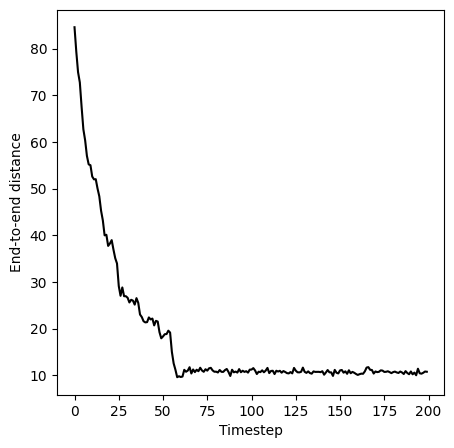

In [ ]:
# here comes the iconic python plotting library
plt.figure(figsize=(5, 5))
plt.plot(distances, '-k')
plt.xlabel('Timestep')
plt.ylabel('End-to-end distance')
plt.show()

#Exercise 1: Run simulations

In the same folder, there are PDBs of a folded and disordered protein. Run them for **50** picoseconds at two different temperatures: T1 = 100K and T2 = 500K. (Make sure to change the names of your output files to distinguish between each run.)

In [ ]:
# folded, 100K
pdb = PDBFile(pdbfile1) #pick the topology (i.e, structure)
ff = ForceField('charmm36.xml') #pick the forcefield. other options include amber96

### 0. Define the system
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 1. Choose parameters of the experiment: temperature, pressure, box size, boundary conditions, etc
temperature= 100*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 50*picoseconds / time_step

### 2. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 3. Setup the simulation to run, saving coordinates time to time:

### 3a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 3b. Minimize energy
simulation.minimizeEnergy()

### 3c. Save coordinates to dcd file and energies to standard output console:
simulation.reporters.append(DCDReporter(drive_path+'folded_100K.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                                temperature=True, progress=True, totalSteps = total_steps))

### 4. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
20.0%,5000,13347.369769573685,101.32055604461458
40.0%,10000,13275.007920351856,101.23157786404992
60.0%,15000,13263.738551015778,98.97961946048486
80.0%,20000,13295.197750439485,102.49282087554732
100.0%,25000,13221.03124810511,100.27881019144914


In [ ]:
# folded, 500K
pdb = PDBFile(pdbfile1) #pick the topology (i.e, structure)
ff = ForceField('charmm36.xml') #pick the forcefield. other options include amber96

### 0. Define the system
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 1. Choose parameters of the experiment: temperature, pressure, box size, boundary conditions, etc
temperature= 500*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 50*picoseconds / time_step

### 2. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 3. Setup the simulation to run, saving coordinates time to time:

### 3a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 3b. Minimize energy
simulation.minimizeEnergy()

### 3c. Save coordinates to dcd file and energies to standard output console:
simulation.reporters.append(DCDReporter(drive_path+'folded_500K.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                                temperature=True, progress=True, totalSteps = total_steps))

### 4. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
20.0%,5000,25115.403400326064,500.4338684691033
40.0%,10000,24868.294328446584,500.65753123667355
60.0%,15000,24671.48473406821,498.9538907525853
80.0%,20000,24721.638967631356,513.3833626366198
100.0%,25000,24721.96678680578,511.18102233880523


In [ ]:
# disordered, 100K
pdb = PDBFile(pdbfile2) #pick the topology (i.e, structure)
ff = ForceField('charmm36.xml') #pick the forcefield. other options include amber96

### 0. Define the system
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 1. Choose parameters of the experiment: temperature, pressure, box size, boundary conditions, etc
temperature= 100*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 50*picoseconds / time_step

### 2. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 3. Setup the simulation to run, saving coordinates time to time:

### 3a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 3b. Minimize energy
simulation.minimizeEnergy()

### 3c. Save coordinates to dcd file and energies to standard output console:
simulation.reporters.append(DCDReporter(drive_path+'disorder_100K.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                                temperature=True, progress=True, totalSteps = total_steps))

### 4. Run!
simulation.step(total_steps)

In [ ]:
# disordered, 500K
pdb = PDBFile(pdbfile2) #pick the topology (i.e, structure)
ff = ForceField('charmm36.xml') #pick the forcefield. other options include amber96

### 0. Define the system
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 1. Choose parameters of the experiment: temperature, pressure, box size, boundary conditions, etc
temperature= 500*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 50*picoseconds / time_step

### 2. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 3. Setup the simulation to run, saving coordinates time to time:

### 3a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 3b. Minimize energy
simulation.minimizeEnergy()

### 3c. Save coordinates to dcd file and energies to standard output console:
simulation.reporters.append(DCDReporter(drive_path+'disorder_500K.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                                temperature=True, progress=True, totalSteps = total_steps))

### 4. Run!
simulation.step(total_steps)

# Exercise 2: More analysis

The MDanalysis package also contains a function for calculating the [radius of gyration](https://userguide.mdanalysis.org/1.1.1/examples/analysis/custom_trajectory_analysis.html#Radius-of-gyration), which is essentially a measure of how compact the protein is. Perform this analysis on the trajectories you obtained in Exercise 1.

For help with plotting: check out the [matplotlib](https://matplotlib.org/) documentation.

In [ ]:
from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)

def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

In [ ]:
# folded, 500K
u1 = md.Universe(pdbfile1, drive_path+'folded_500K.dcd')
p1 = u1.select_atoms('protein')

rog1 = AnalysisFromFunction(radgyr, u1.trajectory,
                           p1, p1.masses,
                           total_mass=np.sum(p1.masses))
rog1.run();

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(rog1.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

In [ ]:
# disordered, 500K
u2 = md.Universe(pdbfile2, drive_path+'disorder_500K')
p2 = u2.select_atoms('protein')

rog2 = AnalysisFromFunction(radgyr, u2.trajectory,
                           p2, p2.masses,
                           total_mass=np.sum(p2.masses))
rog2.run();

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(rog2.results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

# Exercise 3 (optional): Even more analysis

MDanalysis has a lot more packages for analysis, like outputting dihedral angles and hydrogen bonds over time. Feel free to try them out!

https://userguide.mdanalysis.org/stable/examples/analysis/README.html